# Generate a matched distribution to input pyHeadTail

**Remeber that units are different:**
- mm, mrad in transverse
- rad (-pi,pi) and GeV in longitudinal

In [37]:
import pandas as pnd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import metaclass

In [38]:
fpath_ref = '/afs/cern.ch/work/e/esenes/simulations/bump_pyOrbit_test/scripts_bump/Input/'
    
mc = metaclass.twiss(fpath_ref+'twiss_bumpDW2.out')

for k in range(len(mc.NAME)):
    if mc.NAME[k] == 'KICKMARKER':
        print(k)
        elNum = k
        print(mc.NAME[k])

Problem parsing: @ ORBIT_-CT        %le                  -0

Going to be parsed as string
Problem persits, let's ignore it!
0
KICKMARKER


In [39]:
import PyHEADTAIL

from __future__ import division, print_function
range = xrange

import numpy as np
np.random.seed(42)

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sbs
sbs.set_context('talk')

from scipy.constants import c, e, m_p

Import the PS lattice from the PyCERNMachines repository

In [40]:
from PyCERNmachines.CERNmachines import PS

One can choose to initialisate the machine considering linear or non-linear motion using the keyword 'logitudinal_focusing'

In [41]:
Ekin = 1.4e9
gamma = 1 + Ekin * e / (m_p * c**2)
beta = np.sqrt(1 - gamma**-2)

# parameters from the twiss file
beta_x = np.array([mc.BETA11[elNum]])
beta_y = np.array([mc.BETA22[elNum]])
alpha_x = np.array([mc.ALFA11[elNum]])
alpha_y  = np.array([mc.ALFA22[elNum]])
D_x = np.array([mc.DISP1[elNum]])
D_y = np.array([mc.DISP3[elNum]])
Qp_x = mc.DQ1
Qp_y = mc.DQ2
Q_x = mc.Q1
Q_y = mc.Q2

centroid_X = mc.X[elNum]
centroid_Y = mc.Y[elNum]


machine = PS(n_segments=1, gamma=gamma, machine_configuration='LHCbeam_h7', 
             longitudinal_focusing='non-linear', Qp_x=Qp_x, Qp_y=Qp_y,Q_x=Q_x,Q_y=Q_y,
            beta_x=beta_x, alpha_x=alpha_x, D_x=D_x, beta_y=beta_y, alpha_y=alpha_y, D_y=D_y)

# set for operation below transition
machine.longitudinal_map.pop_kick(1)
machine.longitudinal_map.phi_offsets[0] += np.pi


Synchrotron init. From kwargs: gamma = 2.4921045053287254
Synchrotron init. From kwargs: D_x = array([ 3.04895073])
Synchrotron init. From kwargs: D_y = array([ 0.])
Synchrotron init. From kwargs: beta_y = array([ 11.5513756])
Synchrotron init. From kwargs: beta_x = array([ 22.53213283])
Synchrotron init. From kwargs: Qp_y = -6.81718809
Synchrotron init. From kwargs: Qp_x = -5.449947765
Synchrotron init. From kwargs: alpha_x = array([ 0.04617463])
Synchrotron init. From kwargs: machine_configuration = 'LHCbeam_h7'
Synchrotron init. From kwargs: n_segments = 1
Synchrotron init. From kwargs: Q_x = 0.2401386179
Synchrotron init. From kwargs: Q_y = 0.2453163279
Synchrotron init. From kwargs: alpha_y = array([ 0.04677122])
Non-zero dispersion in tracking: ensure the beam has been generated being matched to the correct dispersion!


Now we have the transfer maps, let's generate the beams

generate_6D_Gaussian_bunch_matched() -> will generate a 4D gaussian beam, with a matched gaussian distribution in the longitudinal direction

In [42]:
betagamma = machine.betagamma
print(betagamma)

2.28267055562


In [43]:
n_macroparticles = int(1e4)
intensity = 80e10 # in protons per bunch
epsn_x = 1e-6
epsn_y = 1e-6
epsn_z = 0.5 # [eVs]

bunch = machine.generate_6D_Gaussian_bunch_matched(
    n_macroparticles=n_macroparticles, intensity=intensity, 
    epsn_x=epsn_x, epsn_y=epsn_y, epsn_z=epsn_z)

*** Maximum RMS emittance 1.46369000884eV s.
... distance to target emittance: -4.95e-01
... distance to target emittance: 7.87e-01
... distance to target emittance: 4.88e-01
... distance to target emittance: 1.12e-01
... distance to target emittance: -3.16e-02
... distance to target emittance: 1.25e-03
... distance to target emittance: 9.65e-06
... distance to target emittance: -3.67e-10
... distance to target emittance: 2.54e-06
--> Emittance: 0.499999999633
--> Bunch length:7.74207042289


In [44]:
# position offset to match MADX
bunch.x -= centroid_X
bunch.y -= centroid_Y

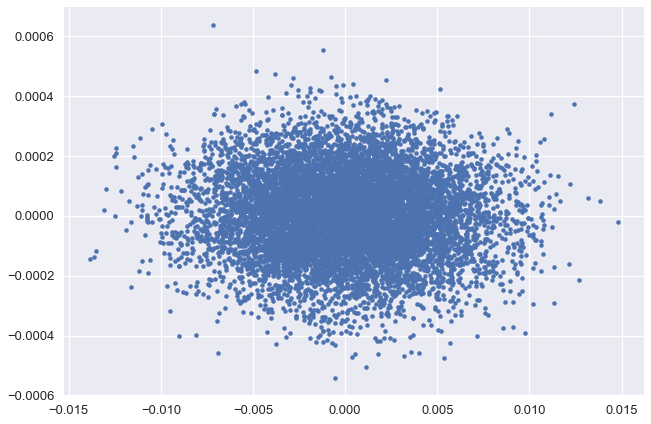

In [45]:
plt.plot(bunch.x,bunch.xp,'.')

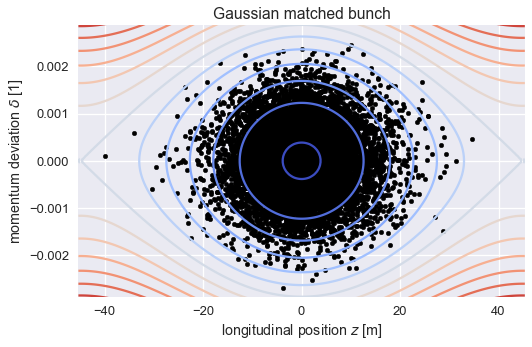

In [46]:
rfsystems = machine.longitudinal_map
rfbucket = rfsystems.get_bucket(bunch)

zz = np.linspace(*rfbucket.interval, num=1000)
dp_max = rfbucket.separatrix(0)
dpp = np.linspace(-dp_max*1.1, dp_max*1.1, num=100)
ZZ, DPP = np.meshgrid(zz, dpp)
HH = rfbucket.hamiltonian(ZZ, DPP)

fig, ax = plt.subplots(1, figsize=(8,5))

ax.scatter(bunch.z, bunch.dp, marker='.', color='black')
ax.contour(ZZ, DPP, HH, 15, cmap=plt.get_cmap('coolwarm'))
ax.set_xlim(rfbucket.interval)
ax.set_ylim(-dp_max, dp_max)
ax.set_xlabel('longitudinal position $z$ [m]')
ax.set_ylabel('momentum deviation $\delta$ [1]')
ax.set_title('Gaussian matched bunch')

# Units conversion for pyOrbit

- $x$,$y$ to mm
- $x^\prime$,$y^\prime$ to mrad
- $z$ remapped in $(-\pi, +\pi)$, so
$$z_\text{new} = z \, \frac{2\pi }{ l_\text{bucket}}$$
- $\frac{\Delta p}{p}$ remapped to $\Delta E$ in GeV, so 
$$
\Delta E = \beta^2 E \frac{\Delta p}{p}
$$

In [47]:
# convert units to mm mrad for pyOrbit
bunch.x = 1e3*bunch.x
bunch.xp = 1e3*bunch.xp
bunch.y = 1e3*bunch.y
bunch.yp = 1e3*bunch.yp

bucketLen = np.sum(np.abs(rfbucket.interval))
bunch.z = bunch.z/bucketLen*2*np.pi
bunch.dp = bunch.dp * machine.beta**2 * Ekin*1e-9

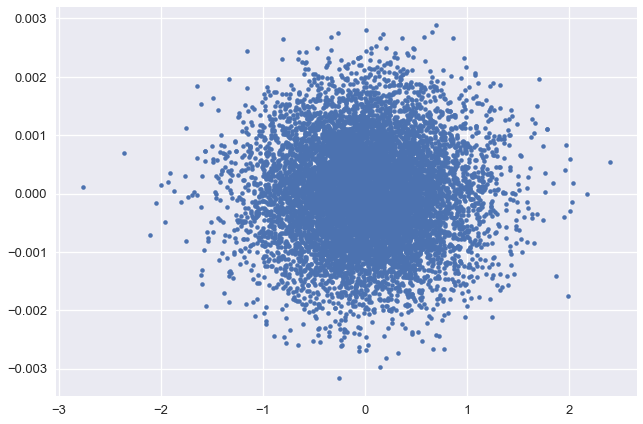

In [48]:
plt.plot(bunch.z, bunch.dp,'.')

In [49]:
# matched transverse distribution, zeros in longitudinal
np.savetxt('PS_matched_transvers.dist',
           np.array([bunch.x, bunch.xp, bunch.y, bunch.yp, bunch.z, bunch.dp]).T,
           delimiter=' ',newline='\n')